# 🔥Transfer Learning in tensorflow Part 2: Fine Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: **Fine Tuning**

## Creating helper function
In previous notebooks, we've written a bunch of helper functions, now we could rewrite them all, however, it is tidious.

So it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks or elsewhere.

We've done this for some of the functions we've used previously.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-09-10 08:04:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-09-10 08:04:14 (82.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-09-10 08:04:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.207, 74.125.196.207, 74.125.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   138MB/s    in 1.2s    

2024-09-10 08:04:21 (138 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check our how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gri

In [ ]:
# Create training and testing directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 0: Building a transfer learning feature extraction model using keras **functional API**

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [ ]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained weights aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50v2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important features)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Compile the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

# 10. Fit the model and save it's history
history_10_percent = model_0.fit(train_data_10_percent,
            epochs=5,
            validation_data=test_data,
            callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extraction")])

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after Global Average Pooling: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240910-080428
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 219s 9s/step - accuracy: 0.2296 - loss: 2.1755 - val_accuracy: 0.7116 - val_loss: 1.3723
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 307s 11s/step - accuracy: 0.7150 - loss: 1.2844 - val_accuracy: 0.8056 - val_loss: 0.9256
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 262s 11s/step - accuracy: 0.8120 - loss: 0.8978 - val_accuracy: 0.8384 - val_loss: 0.7329
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 197s 8s/step - accuracy: 0.8432 - loss: 0.7522 - val_accuracy: 0.8544 - val_loss: 0.6355
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 204s 9s/step - accuracy: 0.8603 - loss: 0.6232 - val_accuracy: 0.8576 - val_loss: 0.5764


In [ ]:
# Evaluate on the full dataset
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.8670 - loss: 0.5631


[0.5763538479804993, 0.8575999736785889]

In [ ]:
# Summary of the base model
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              0 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, None, None, 16) │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, None, None, 16) │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, None, None, 16) │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, None, None, 64) │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, None, None, 64) │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, None, None, 64) │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, None, None, 32) │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, None, None, 32) │            128 │ block2a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
# Summary of model_0
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

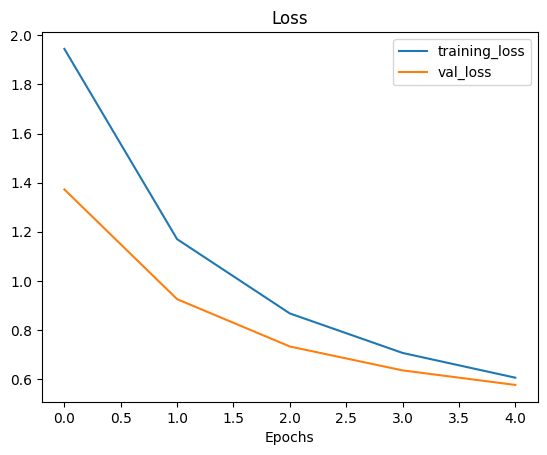

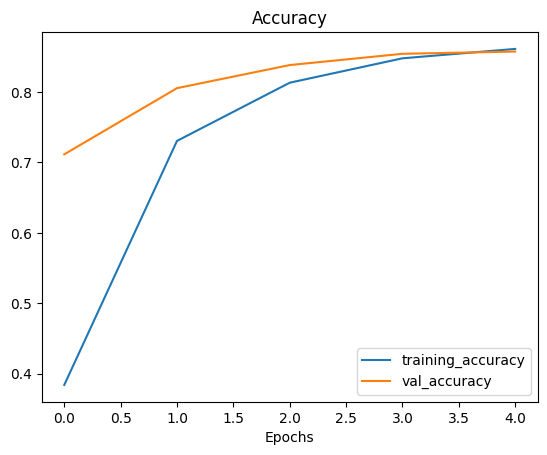

In [ ]:
# Plot loss curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the global average pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)...

But then when it passes through `GlobalAveragePooling2D`, it turnns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to `GlobalAveragePooling2D` layer

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"random input tensor:\n {input_tensor}\n")

# Pass the input_tensor through the GlobalAveragePooling2D
global_average_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Shape after passing through GlobalAveragePooling2D:\n {global_average_pooling_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input_tensor: {input_tensor.shape}")
print(f"Shape of global_average_pooling_tensor: {global_average_pooling_tensor.shape}")

random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

Shape after passing through GlobalAveragePooling2D:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input_tensor: (1, 4, 4, 3)
Shape of global_average_pooling_tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

In [ ]:
tf.reduce_mean(input_tensor, axis=[1, 2]) == global_average_pooling_tensor

<tf.Tensor: shape=(1, 3), dtype=bool, numpy=array([[ True,  True,  True]])>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of training data, but how does it go with 1% of training data... how about we setup a bunch of experiments to find out:

2. **model_1** - use feature extraction transfer learning with 10% of training data with data augmentation
3. **model_2** - use fine tuning transfer learning on 10% of training data with data augmentation.
4. **model_3** - use fine tuning transder learning on 100% of the training data with data augmentation.

## Getting and preprocessing data for `model_1`

## model_1: feature extraction transfer learning model with 10% of data and data augmentation

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create model_1 with data augmentation built-in
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name="data_augmentation")

# Set the input shape of the model
input_shape = (224, 224, 3)

# Create a frozen base model (aka backbone)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in betweeen)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # pass the augmented images to the base model but keep in in inference mode, this also ensures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])


In [ ]:
model_1.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, None, None, 1280)    │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

## Creating a model checkpoint callback
The model checkpoint callback intermediatley saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.weights.h5"

# Create a model checkpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [ ]:
# fit the model_1
history_10_percent_data_aug = model_1.fit(train_data_10_percent,
            epochs=5,
            validation_data=test_data,
            callbacks=[create_tensorboard_callback("transfer_learning", "10%_data_aug"),
                       checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10%_data_aug/20240910-100308
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1458 - loss: 2.2493
Epoch 1: saving model to 10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 277s 11s/step - accuracy: 0.1500 - loss: 2.2431 - val_accuracy: 0.6260 - val_loss: 1.5718
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5840 - loss: 1.5777
Epoch 2: saving model to 10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 195s 8s/step - accuracy: 0.5843 - loss: 1.5743 - val_accuracy: 0.7412 - val_loss: 1.1330
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6561 - loss: 1.2528
Epoch 3: saving model to 10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 206s 8s/step - accuracy: 0.6574 - loss: 1.2498 - val_accuracy: 0.7760 - val_loss: 0.9163
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7564 - loss

In [ ]:
# What were model_0 results
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.8570 - loss: 0.5743


[0.5763539671897888, 0.8575999736785889]

In [ ]:
# Check model_1 results on all test data
results_10_percent_data_aug = model_1.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.8222 - loss: 0.7067


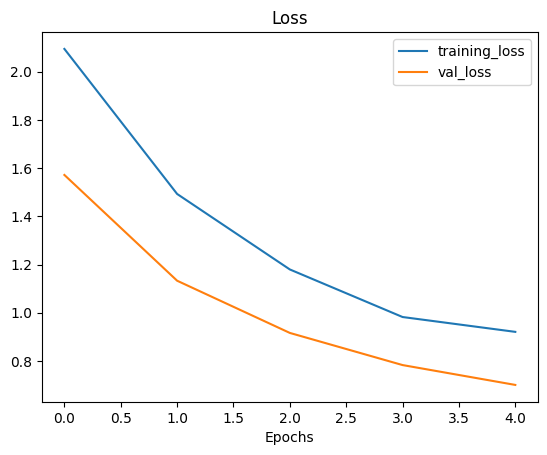

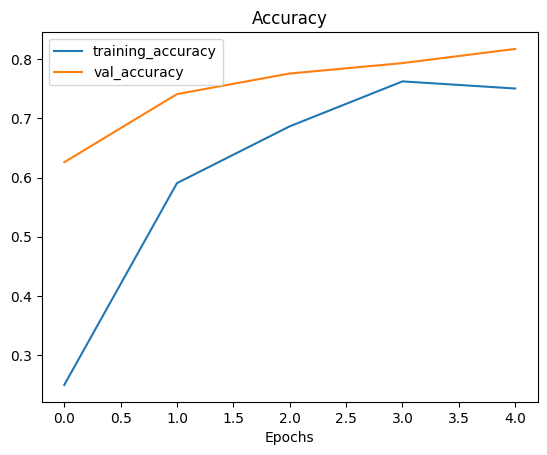

In [ ]:
# Plot model_1 loss curves
plot_loss_curves(history_10_percent_data_aug)

## Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint

In [ ]:
# Load in saved model weights and evaluate model
model_1.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_1 with loaded weights
loaded_weights_model_results = model_1.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.8148 - loss: 0.7092


In [ ]:
# If the result of our prev evaluated model_1 match the loaded weight, everything has worked!!
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
results_10_percent_data_aug

[0.7005529403686523, 0.8176000118255615]

In [ ]:
loaded_weights_model_results

[0.7005528211593628, 0.8176000118255615]

In [ ]:
import numpy as np
np.isclose(results_10_percent_data_aug, loaded_weights_model_results)

array([ True,  True])

## Model 2: Fine tuning an existing model on 10% of data
>🔑 **Note:** Fine tuning usually works best *after* training a feature extraction model for a few epochs with large amount of custom data

In [ ]:
# Layers in loaded model
model_1.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=data_augmentation, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

In [ ]:
# Are these layers trainable
for layer in model_1.layers:
  print(f"{layer.name}:  {layer.trainable}")

input_layer:  True
data_augmentation:  True
efficientnetv2-b0:  False
global_average_pooling_layer:  True
output_layer:  True


In [ ]:
# How many trainable variables are there in the base_model
print(len(model_1.layers[2].trainable_variables))

0


In [ ]:
# To begin fine tuning, let's start by setting last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our model every time we make a change)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001), # when fine-tuning, you typically want to lower you learning rate by 10x
                metrics=["accuracy"])

>🔑 **Note:** When using fine-tuning it's best practice to lower to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is atleast 10x.

In [ ]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_1.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_41 False
1 rescaling_35 False
2 normalization_28 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a

In [ ]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there
print(len(model_1.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_1 except with more trainable layers)
history_fine_tune_10_percent_data_aug = model_1.fit(train_data_10_percent,
                                                    epochs=fine_tune_epochs,
                                                    validation_data=test_data,
                                                    initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from prev last epoch
                                                    callbacks=[create_tensorboard_callback("transfer_learning",
                                                                                           "10%_fine_tune_data_aug")
                                                    ])

Saving TensorBoard log files to: transfer_learning/10%_fine_tune_data_aug/20240910-122910
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 239s 9s/step - accuracy: 0.7331 - loss: 1.0561 - val_accuracy: 0.8096 - val_loss: 0.7565
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 252s 9s/step - accuracy: 0.7502 - loss: 0.9246 - val_accuracy: 0.8140 - val_loss: 0.6902
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 314s 11s/step - accuracy: 0.7758 - loss: 0.8897 - val_accuracy: 0.8284 - val_loss: 0.6325
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 263s 11s/step - accuracy: 0.7848 - loss: 0.7999 - val_accuracy: 0.8332 - val_loss: 0.5892
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 261s 11s/step - accuracy: 0.8116 - loss: 0.7463 - val_accuracy: 0.8424 - val_loss: 0.5503
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 262s 11s/step - accuracy: 0.7941 - loss: 0.7125 - val_accuracy: 0.8432 - val_loss: 0.5407


In [ ]:
results_fine_tune_10_percent = model_1.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.8492 - loss: 0.5376


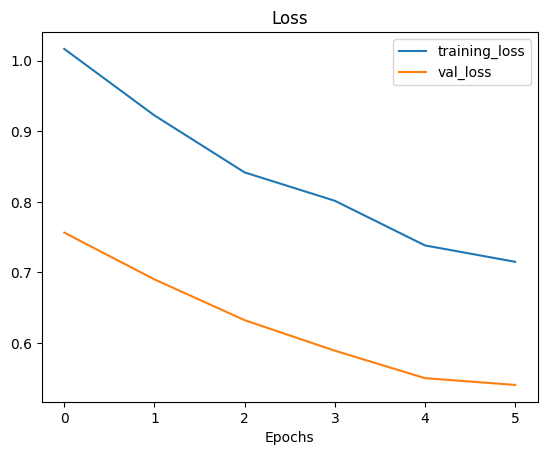

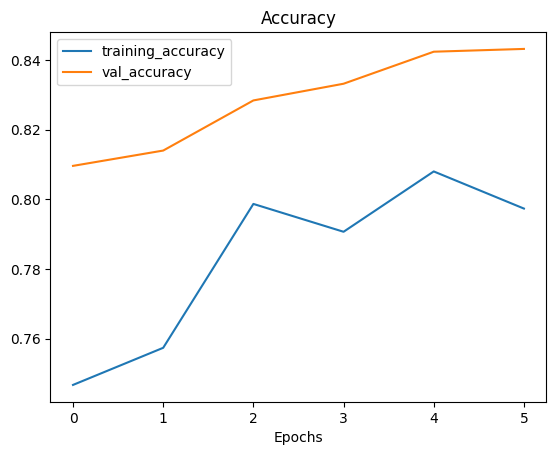

In [ ]:
# Checkout the loss curves of our fine-tuned model
plot_loss_curves(history_fine_tune_10_percent_data_aug)

The `plot_loss_curves()` function works great with models which have been only fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine tuning).

In [ ]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compare two tensorflow history objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.ylim([0.4, 1])
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.ylim([0, 3.0])
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()


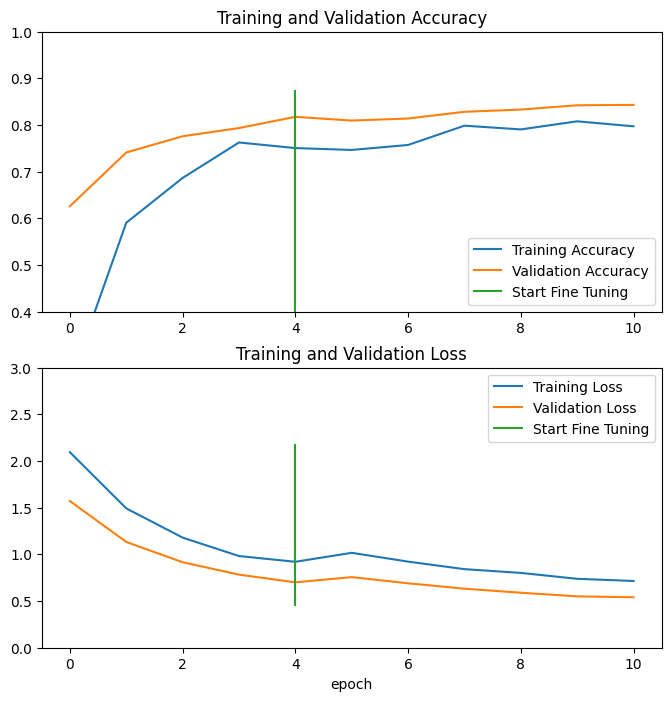

In [ ]:
compare_histories(history_10_percent_data_aug, history_fine_tune_10_percent_data_aug)

# Model 3: Fine-tuning an existing model on all of the data

In [ ]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2024-09-10 14:50:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.207, 74.125.196.207, 74.125.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  55.8MB/s    in 9.0s    

2024-09-10 14:50:59 (55.0 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images are we working with
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 image_size=IMG_SIZE,
                                                                                 label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


To train a fine-tuning model (model_3) we need to revert model_1 back to it's feature extraction weights.

In [ ]:
# Load weights from checkpoint, that way we can fine tune from
# the same stage the 10 percent data model was fine tuned from
model_1.load_weights(checkpoint_path)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


All we've done is:
1. trained a feature extraction transfer learning model for 5 epochs on 10% of data with data augmentation (model_1) and we saved model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on 10% of the data for a further 5 epochs with the top ten layers of the base model unfrozen (model_2).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_3).

In [ ]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_1.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 True
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# Let's drill into our base model and see what layers are trainable
for layer_number, layer in enumerate(model_1.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_41 False
1 rescaling_35 False
2 normalization_28 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a

In [ ]:
# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [151]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_1.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback("transfer_learning",
                                                                                  "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20240910-171342
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 807s 3s/step - accuracy: 0.8522 - loss: 0.4673 - val_accuracy: 0.9180 - val_loss: 0.2368
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 808s 3s/step - accuracy: 0.8510 - loss: 0.4624 - val_accuracy: 0.9200 - val_loss: 0.2307
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 807s 3s/step - accuracy: 0.8587 - loss: 0.4397 - val_accuracy: 0.9264 - val_loss: 0.2231
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 848s 3s/step - accuracy: 0.8659 - loss: 0.4232 - val_accuracy: 0.9268 - val_loss: 0.2211
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 799s 3s/step - accuracy: 0.8706 - loss: 0.4141 - val_accuracy: 0.9288 - val_loss: 0.2156
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 798s 3s/step - accuracy: 0.8772 - loss: 0.4057 - val_accuracy: 0.9324 - val_loss: 0.2120


In [152]:
# Let's evaluate on all of our test data
results_fine_tune_full_data = model_1.evaluate(test_data)
results_fine_tune_full_data

79/79 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9272 - loss: 0.2206


[0.21197792887687683, 0.9323999881744385]

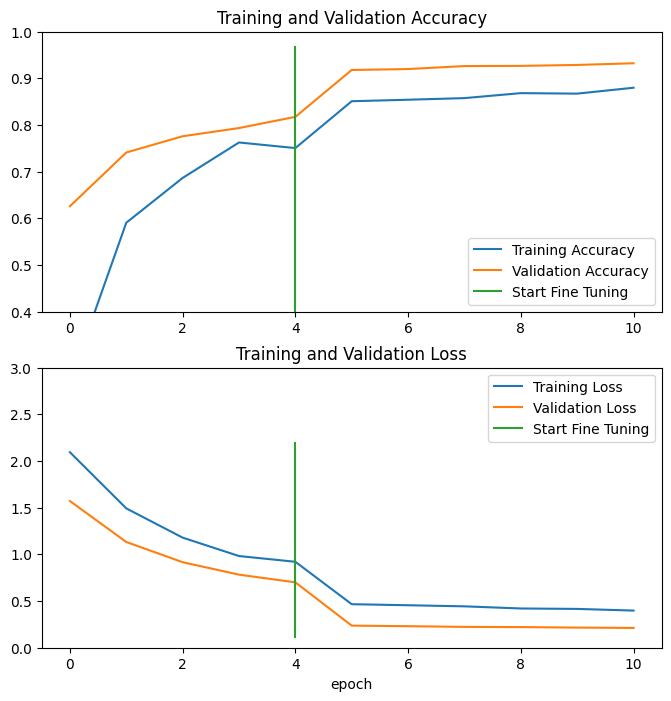

In [153]:
# How did fine tuning go with more data?
compare_histories(history_10_percent_data_aug, history_fine_10_classes_full)